---

    RAPPORT AUTOMATIQUE SUCCINCT   
    DE L'ANALYSE PRÉLIMINAIRE   
    DU JEU DE DONNÉES ET DE SES DONNÉES   
    
---


Si des personnes souhaitent lancer une analyse préliminaire sur des données provenant d'un kit smart citizen, ce notebook jupyter délivre une série d'informations préliminaires sur le jeu de données et sur les données.

Pour que ce notebook fonctionne il est nécessaire de:
- installer anaconda
- placer ce notebook dans un dossier, et de créer un répertorie appelé "00_DONNEES_SOURCE" et d'y placer le fichier csv des données provenant du kit smart-citizen en le nommant "data_source.csv"

Le résultat de ce rapport se situe en cellule 3.

Il vous faut relancer ce notebook pour mettre à jour l'analyse avec vos propres données.

In [1]:

# on importe la librairie "os" pour localiser les fichiers
import os

# on importe les librairies de base pour la data-science
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# on importe des modules spécifiques de visualisation
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot

# on importe des librairies spécifiques pour la data-science
# statsmodels
from statsmodels.tsa.deterministic import DeterministicProcess

# sklearn
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, silhouette_score, calinski_harabasz_score,davies_bouldin_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# scipy
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [2]:
def delivre_infos_clefs_issues_de_l_analyse_preliminaire():
    
    # ON ESSAYE DE CHARGER LES 3 PREMIÈRES LIGNES DU JEU DE DONNÉES
    # =============================================================================
    # juste pour voir si ça se charge bien.
    def charge_3_premieres_lignes_des_donnees_sources():
        return (
            pd.read_csv(
                os.path.join(
                    os.getcwd(),
                    "00_DONNEES_SOURCE",
                    "data_source.csv"
                ),
                nrows=3,
            )
        )
    # DÉCLARATION D'UN DICTIONNAIRE DE MISE EN CONFORMITÉ DES NOMS DE COLONNES
    # =============================================================================
    # Déclaration de la liste des colonnes des données source
    def liste_des_noms_de_colonnes_du_jeu_de_donnees_source():
        return charge_3_premieres_lignes_des_donnees_sources().columns.tolist()

    # déclaration d'une liste de noms de colonnes conformes aux standard python
    def liste_des_noms_de_colonnes_conformes_en_francais():
        return [
            'date_de_captation',
             'humidite_en_pourcentage',
             'temperature_de_l_air_en_celsus',
             'pression_barometrique_en_kpascal',
             'pourcentage_batterie',
             'eco2_en_ppm',
             'tvoc_en_ppb',
             'lumiere_en_lux',
             'pm_1_en_ug_par_m3',
             'bruit_en_dba',
             'pm_10_en_ug_par_m3',
             'pm_2_5_en_ug_par_m3']

    # Déclaration d'un dictionnaire des noms de colonnes avant et après
    def dictionnaire_noms_de_colonnes():
        return (
            dict(
                zip(
                liste_des_noms_de_colonnes_du_jeu_de_donnees_source(),
                liste_des_noms_de_colonnes_conformes_en_francais()
                )
            )
        )
    
    # déclaration d'une liste de noms de colonnes dans le bon ordre
    def liste_des_noms_de_colonnes_dans_le_bon_ordre():
        return [
            'date_de_captation',
             'humidite_en_pourcentage',
             'temperature_de_l_air_en_celsus',
             'pression_barometrique_en_kpascal',
             'lumiere_en_lux',
             'bruit_en_dba',
             'eco2_en_ppm',
             'tvoc_en_ppb',
             'pm_1_en_ug_par_m3',
             'pm_2_5_en_ug_par_m3',
             'pm_10_en_ug_par_m3',
             'pourcentage_batterie'
        ]
    
    def charge_les_donnees_sources():
        return (
            # on lit le fichier CSv
            pd.read_csv(
                os.path.join(
                    os.getcwd(),
                    "00_DONNEES_SOURCE",
                    "data_source.csv"
                ),
                # on passe le format de date sur la variable de date
                parse_dates=["timestamp"],
                # on applique un accélérateur même si c'est déprécié depuis pandas 2.0
                infer_datetime_format=True
            )
            # on renomme les colonne avec les noms normés en français
            .rename(columns=dictionnaire_noms_de_colonnes())
            # on remet les colonnes dans un ordre, pour qu'elles soient regroupés par famille
            [liste_des_noms_de_colonnes_dans_le_bon_ordre()]
            # et on retire les informations de fuseau horaire qui ne servent à rien ici
            .assign(date_de_captation = lambda x: x.date_de_captation.dt.tz_localize(None))
        )
    
    donnees_source = charge_les_donnees_sources()
    
    def nombre_de_ligne_fichier_source():
        return donnees_source.shape[0]

    def nombre_de_donnees_dans_le_fichier_source():
        return (
            donnees_source.shape[0] * donnees_source.shape[1]
        )
    
    def affiche_dimensions_du_jeu_de_données():
        return f"""
        Le jeu de données comporte :
        - {donnees_source.shape[0]} lignes
        - {donnees_source.shape[1]} colonnes
        Soit: {donnees_source.shape[0] * donnees_source.shape[1]} données
        """
    
    def affiche_le_nombre_de_manquants():
        return f"""
        Il y a {donnees_source.isna().sum().sum()} valeurs manquantes
        ce qui représente {donnees_source.isna().sum().sum()/nombre_de_donnees_dans_le_fichier_source():.2%} des données.
        """
    
    def nombre_de_lignes_avec_au_moins_1_manquant():
        return (
            donnees_source.isnull().any(axis=1).sum()
        )
    
    def affiche_le_nombre_de_lignes_avec_au_moins_un_manquant():
        return f"""
        Le jeu de données comporte {nombre_de_lignes_avec_au_moins_1_manquant()} lignes avec au moins 1 manquant
        ce qui représente {nombre_de_lignes_avec_au_moins_1_manquant()/donnees_source.shape[0]:.2%} des lignes.
        """
    
    def date_debut():
        return donnees_source.date_de_captation.min()

    def date_fin():
        return donnees_source.date_de_captation.max()
    
    def affiche_les_dates_de_la_periode_d_observation():
        return f"""
        La date de debut des observations est le  : {donnees_source.date_de_captation.min()}
        La date de fin des observations est le    : {donnees_source.date_de_captation.max()}
        Ce qui fait une période d'observations de : {donnees_source.date_de_captation.max() - donnees_source.date_de_captation.min()}
        """
    
    def affiche_le_resultat_du_test_de_chronologie_des_enregistrements():
        if sum(donnees_source.date_de_captation.diff().astype('timedelta64[s]') < 1) > 0:
            return f"""
        Certaines dates ne sont pas entrées dans l'ordre chronologiques
            """
        else:
            return f"""
        Les dates sont toutes enregistrées dans un ordre chronologique
            """
    
    def delivre_le_df_dates_de_captations_et_ligne_de_temps():
        return (
            # on prend les données source
            donnees_source
            # on en fait une copie
            .copy()
            # df contenant uniquement la date de captation
            [["date_de_captation"]]
            # on trie par date
            .sort_values(by="date_de_captation")
            # on ajoute une colonne qui fait la différence entre ligne n+1 et ligne n
            # cela donne l'interval de temps avec la précédente observation
            # la première ligne est égale à zéro. 
            .assign(
                intervalle_avec_precedente_observation_en_secondes = lambda df: (
                    df
                    .date_de_captation
                    .diff()
                    .fillna(pd.Timedelta(0))
                    .astype('timedelta64[s]')
                )
            )
            # on ajoute une colonne, qui donne l'intervalle de temps avec la prochaine observation
            # on glisse d'un cran vers le haut les valeurs 
            .assign(
                intervalle_de_temps_avec_observation_suivante_en_secondes = lambda df: (
                    df
                    .intervalle_avec_precedente_observation_en_secondes
                    .shift(periods=-1)
                    .fillna(pd.Timedelta(60))
                    .astype('timedelta64[s]')
                )
            )
            # on ajoute une ligne de temps en secondes, qui n'est autre sur le cumul des 
            # intervalles de temps en partant de zéro.
            .assign(ligne_de_temps_en_secondes = lambda df: df.intervalle_avec_precedente_observation_en_secondes.cumsum())
        )
    
    def affiche_le_resultat_du_test_intervalles_60_secondes():
        if sum(
                delivre_le_df_dates_de_captations_et_ligne_de_temps()
                .intervalle_de_temps_avec_observation_suivante_en_secondes
                == 60
            ) > 1:
            return f"""
        Les captations se sont faites à intervalles réguliers de 60 secondes
            """
        else:
            return f"""
        Les captations ne se sont pas faites à intervalles réguliers de 60 secondes
            """
    def liste_variables_descriptives():
        return (
            ['humidite_en_pourcentage',
             'temperature_de_l_air_en_celsus',
             'pression_barometrique_en_kpascal',
             'lumiere_en_lux',
             'bruit_en_dba',
             'eco2_en_ppm',
             'tvoc_en_ppb',
             'pm_1_en_ug_par_m3',
             'pm_2_5_en_ug_par_m3',
             'pm_10_en_ug_par_m3',
             'pourcentage_batterie']
        )
    
    def liste_variables_descriptives_pertinentes():
        return (
            ['humidite_en_pourcentage',
             'temperature_de_l_air_en_celsus',
             'pression_barometrique_en_kpascal',
             'lumiere_en_lux',
             'bruit_en_dba',
             'eco2_en_ppm',
             'tvoc_en_ppb',
             'pm_1_en_ug_par_m3',
             'pm_2_5_en_ug_par_m3',
             'pm_10_en_ug_par_m3']
        )
    
    def df_source_avec_numero_tranche_horaire_semaine():
        return (
            donnees_source
            # on travaille sur une copie
            .copy()
            # on tri par date
            .sort_values(by="date_de_captation")
            # on défini les dates comme index, pour faciliter la création des varaibles de dates calculeées
            .assign(num_tranche_horaire_1_a_24 = lambda df: (df.date_de_captation.dt.hour +1))
            .assign(numero_jour_semaine_1_a_7 = lambda df: (df.date_de_captation.dt.dayofweek +1))
            .assign(
                numero_tranche_horaire_semaine = lambda df: (
                    ( (df.numero_jour_semaine_1_a_7 - 1) *24 ) + df.num_tranche_horaire_1_a_24
                )
            )
            .drop(columns=["num_tranche_horaire_1_a_24","numero_jour_semaine_1_a_7"])

        )
    
    def df_source_sur_ligne_de_temps_avec_tranches_horaire_semaine():
        return (
            df_source_avec_numero_tranche_horaire_semaine()
            .copy()
            #.sample(50)

            .sort_values(by="date_de_captation") 
            .assign(
                intervalle_avec_precedente_observation_en_secondes = lambda df: (
                    df
                    .date_de_captation
                    .diff()
                    .fillna(pd.Timedelta(0))
                    .astype('timedelta64[s]')
                )
            )
            .assign(ligne_de_temps_en_secondes = lambda df: df.intervalle_avec_precedente_observation_en_secondes.cumsum())
            .set_index("ligne_de_temps_en_secondes")
            .drop(columns=["date_de_captation"])
            [liste_variables_descriptives_pertinentes()]
        )
    
    def affiche_les_graphes_d_evolution_des_variables_dans_le_temps():
        plt.figure()
        plt.clf()
        (
            df_source_avec_numero_tranche_horaire_semaine()
            .copy()
            .sort_values(by="date_de_captation")
            .set_index("date_de_captation")
            [liste_variables_descriptives_pertinentes()]
            .plot(style=".", markersize=2, subplots=True, figsize=(12, 12), legend=True)
        );
        plt.show()
        plt.close("all")
    
    
    return (
        print(f"""
        ###
        RAPPORT AUTOMATIQUE SUCCINCT 
        D'ANALYSE PRÉLIMINAIRE
        ###
        
        {affiche_dimensions_du_jeu_de_données()}
        {affiche_le_nombre_de_manquants()}
        {affiche_le_nombre_de_lignes_avec_au_moins_un_manquant()}
        {affiche_les_dates_de_la_periode_d_observation()}
        {affiche_le_resultat_du_test_de_chronologie_des_enregistrements()}
        {affiche_le_resultat_du_test_intervalles_60_secondes()}
        
        Si vous trouvez que les caractéristiques ci-dessus sont anormales
        alors il vous faudra analyser plus en détails ces caractéristiques.
        Cette analyse automatique n'inclue pas ces analyses approfondies.
        
        La liste des variables descriptives étudiées, est restreinte aux variables suivantes: 
        {liste_variables_descriptives_pertinentes()}
        
        La variable de batterie n'est pas étudiée. Si vous souhaitez l'étudier, 
        il vous faudra réaliser une étude spécifique.
        
        L'évolution des variables dans le temps, donne le graphique suivant :
        """),
        affiche_les_graphes_d_evolution_des_variables_dans_le_temps(),
        print(f"""
        À partir de là, plusieurs études approfondies peuvent être pratiquées, incluant:
        - analyse des manquants éventuels
        - analyse des phénomènes de batches éventuels
        - analyse des intervalles de captations
        - analyse des dépassements de normes de pollution
        - repérage des plages de valeurs par tranche horaire de semaine
        - modélisation sous formes de "clusters"
        - calculs de probabilités par tranche horaire de semaine
        
        À vous de décider si vous souhaitez pratiquer ces analyses supplémentaires.
        """)
        
        
    )


        ###
        RAPPORT AUTOMATIQUE SUCCINCT 
        D'ANALYSE PRÉLIMINAIRE
        ###
        
        
        Le jeu de données comporte :
        - 1055697 lignes
        - 12 colonnes
        Soit: 12668364 données
        
        
        Il y a 2139336 valeurs manquantes
        ce qui représente 16.89% des données.
        
        
        Le jeu de données comporte 232052 lignes avec au moins 1 manquant
        ce qui représente 21.98% des lignes.
        
        
        La date de debut des observations est le  : 2019-06-05 14:49:03
        La date de fin des observations est le    : 2022-07-12 13:28:29
        Ce qui fait une période d'observations de : 1132 days 22:39:26
        
        
        Certaines dates ne sont pas entrées dans l'ordre chronologiques
            
        
        Les captations ne se sont pas faites à intervalles réguliers de 60 secondes
            
        
        Si vous trouvez que les caractéristiques ci-dessus sont anormales
     

<Figure size 640x480 with 0 Axes>

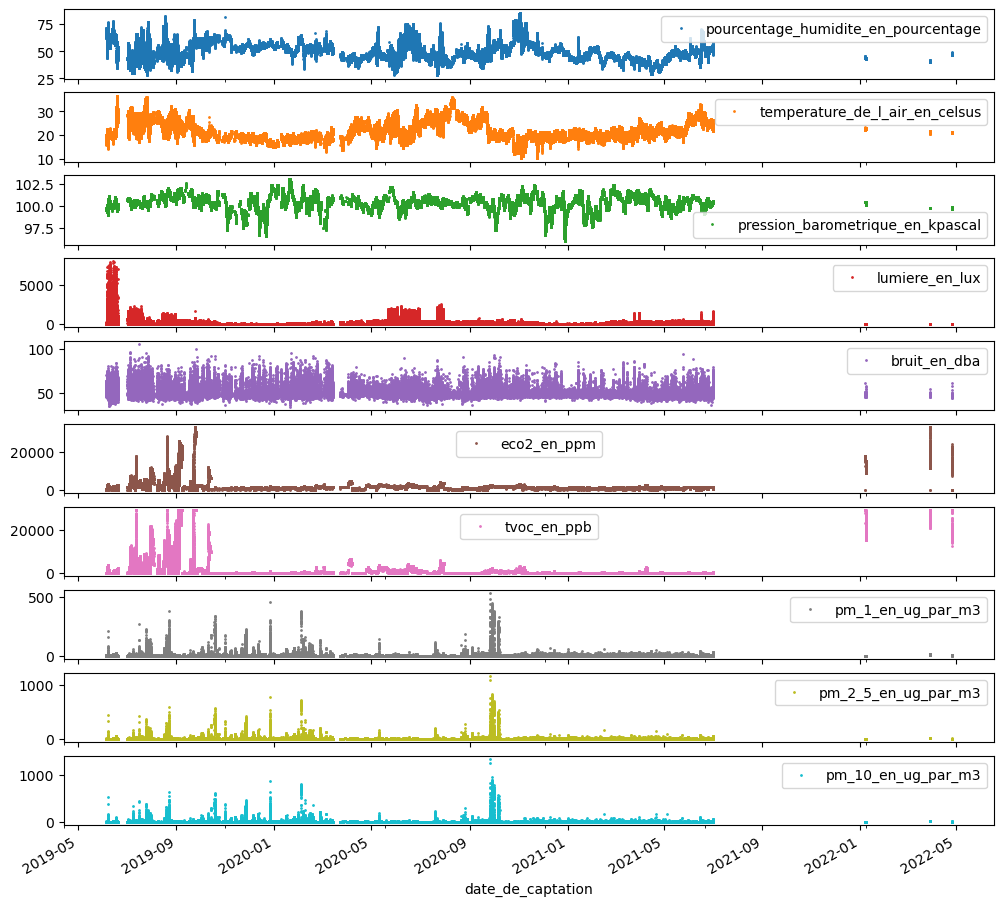


        À partir de là, plusieurs études approfondies peuvent être pratiquées, incluant:
        - analyse des manquants éventuels
        - analyse des phénomènes de batches éventuels
        - analyse des intervalles de captations
        - analyse des dépassements de normes de pollution
        - repérage des plages de valeurs par tranche horaire de semaine
        - modélisation sous formes de "clusters"
        - calculs de probabilités par tranche horaire de semaine
        
        À vous de décider si vous souhaitez pratiquer ces analyses supplémentaires.
        
CPU times: user 3min 41s, sys: 4.04 s, total: 3min 45s
Wall time: 3min 45s


(None, None, None)

In [3]:
%%time
delivre_infos_clefs_issues_de_l_analyse_preliminaire()